In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.models as models
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/TacTile Segmentation AI

/content/drive/MyDrive/TacTile Segmentation AI


In [ ]:
## 데이터 전처리
from os import listdir

trainset = [[], []]
testset = [[], []]

In [ ]:
def preprocess_y(img):
  preprocess_result = []

  for i in img:
    preprocess_result.append([])
    for j in i:
      label = 0 if j[2] == 84 else 1
      preprocess_result[-1].append(label)

  preprocess_result = np.array(preprocess_result)
  return preprocess_result

In [ ]:
for x_path, y_path in zip(sorted(listdir("./dataset/yellow_dataset/trainset/x")), sorted(listdir("./dataset/yellow_dataset/trainset/y"))):
  x_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/trainset/x/" + x_path), cv2.COLOR_BGR2RGB)
  y_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/trainset/y/" + y_path), cv2.COLOR_BGR2RGB)

  preprocess_y_image = preprocess_y(y_image)

  trainset[0].append(np.transpose(x_image))
  trainset[1].append(np.array([preprocess_y_image]))

In [ ]:
train_x, train_y = np.array(trainset[0]), np.array(trainset[1])
print(train_x.shape, train_y.shape)

(300, 3, 256, 256) (300, 1, 256, 256)


In [ ]:
for x_path, y_path in zip(sorted(listdir("./dataset/yellow_dataset/testset/x")), sorted(listdir("./dataset/yellow_dataset/testset/y"))):
  x_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/testset/x/" + x_path), cv2.COLOR_BGR2RGB)
  y_image = cv2.cvtColor(cv2.imread("./dataset/yellow_dataset/testset/y/" + y_path), cv2.COLOR_BGR2RGB)

  preprocess_y_image = preprocess_y(y_image)

  testset[0].append(np.transpose(x_image))
  testset[1].append(np.array([preprocess_y_image]))

In [ ]:
test_x, test_y = np.array(testset[0]), np.array(testset[1])
print(test_x.shape, test_y.shape)

(50, 3, 256, 256) (50, 1, 256, 256)


In [ ]:
np.save("./yellow_train_x.npy", train_x)
np.save("./yellow_train_y.npy", train_y)
np.save("./yellow_test_x.npy", test_x)
np.save("./yellow_test_y.npy", test_y)

In [2]:
train_x = np.load("./yellow_train_x.npy")
train_y = np.load("./yellow_train_y.npy")
test_x = np.load("./yellow_test_x.npy")
test_y = np.load("./yellow_test_y.npy")

In [3]:
class YellowFCN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=2, padding=1)
        self.down_bn1 = nn.BatchNorm2d(3)

        self.conv2 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.down_bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1)
        self.down_bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1)
        self.down_bn4 = nn.BatchNorm2d(256)

        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn3 = nn.BatchNorm2d(64)

        self.deconv2 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn2 = nn.BatchNorm2d(16)

        self.deconv1 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.up_bn1 = nn.BatchNorm2d(3)

        self.classifier = nn.ConvTranspose2d(3, 1, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1 = self.down_bn1(conv1)

        conv2 = self.conv2(bn1)
        bn2 = self.down_bn2(conv2)

        conv3 = self.conv3(bn2)
        bn3 = self.down_bn3(conv3)

        conv4 = self.conv4(bn3)
        bn4 = self.down_bn4(conv4)

        out = self.deconv3(bn4)
        out = self.up_bn3(out)

        out = self.deconv2(out + bn3)
        out = self.up_bn2(out)

        out = self.deconv1(out + bn2)
        out = self.up_bn1(out)

        out = self.classifier(out)

        return out

In [10]:
summary(YellowFCN().cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]              84
       BatchNorm2d-2          [-1, 3, 128, 128]               6
            Conv2d-3           [-1, 16, 64, 64]             448
       BatchNorm2d-4           [-1, 16, 64, 64]              32
            Conv2d-5           [-1, 64, 32, 32]           9,280
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 16, 16]         147,712
       BatchNorm2d-8          [-1, 256, 16, 16]             512
   ConvTranspose2d-9           [-1, 64, 32, 32]         147,520
      BatchNorm2d-10           [-1, 64, 32, 32]             128
  ConvTranspose2d-11           [-1, 16, 64, 64]           9,232
      BatchNorm2d-12           [-1, 16, 64, 64]              32
  ConvTranspose2d-13          [-1, 3, 128, 128]             435
      BatchNorm2d-14          [-1, 3, 1

In [12]:
train_set = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
trainloader = DataLoader(train_set, batch_size=100, shuffle=True)

In [13]:
model = YellowFCN().cuda()
criterion = nn.BCELoss().cuda()
optimizer = Adam(model.parameters(), lr=0.002)

In [14]:
val_set_x = torch.from_numpy(test_x[:25]).float().cuda()
val_set_y = torch.from_numpy(test_y[:25]).float().cuda()
val_criterion = nn.BCELoss().cuda()

def get_val_loss(val_model):
    pred = val_model(val_set_x)
    pred = nn.functional.sigmoid(pred)
    val_loss = val_criterion(pred, val_set_y)
    
    val_loss /= 100

    return val_loss

In [15]:
avg_loss_log = []
val_loss_log = []

for epoch in range(10):
    avg_loss = 0

    for x, y in trainloader:
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()
        pred = model(x)
        pred = nn.functional.sigmoid(pred)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        avg_loss += loss

    avg_loss /= 300
    validation_loss = get_val_loss(model)
    
#     avg_loss_log.append(avg_loss)
#     val_loss_log.append(validation_loss)

    print(f"epoch: {epoch}, avg_loss: {avg_loss}, val_loss: {validation_loss}")

c:\users\simplepro\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, avg_loss: 0.02058120258152485, val_loss: 0.005757532082498074
epoch: 1, avg_loss: 0.01832767017185688, val_loss: 0.005196671932935715
epoch: 2, avg_loss: 0.016572199761867523, val_loss: 0.004704194609075785
epoch: 3, avg_loss: 0.015021182596683502, val_loss: 0.00426681712269783
epoch: 4, avg_loss: 0.013648878782987595, val_loss: 0.003874033223837614
epoch: 5, avg_loss: 0.01240017730742693, val_loss: 0.003521100152283907
epoch: 6, avg_loss: 0.01127627119421959, val_loss: 0.003204034175723791
epoch: 7, avg_loss: 0.010272516869008541, val_loss: 0.002919543534517288
epoch: 8, avg_loss: 0.009376192465424538, val_loss: 0.002664686180651188
epoch: 9, avg_loss: 0.008552388288080692, val_loss: 0.002434638561680913


In [28]:
pred = nn.functional.sigmoid(model(torch.Tensor(test_x[100:110]).float().cuda())).cpu().detach().numpy()
print(pred.shape)

(10, 1, 256, 256)


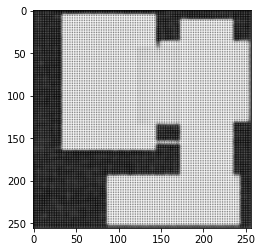

In [36]:
plt.imshow(np.transpose(pred[1][0]), cmap="gray")

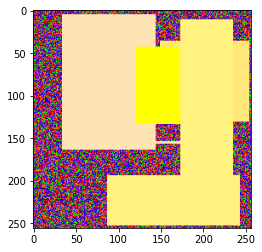

In [35]:
plt.imshow(np.transpose(test_x[101]))

In [37]:
torch.save(model.state_dict(), "./yellow_fcn_weights.pkl")

In [4]:
tactile_fcn = YellowFCN()

In [5]:
for name, param in tactile_fcn.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
conv1.bias True
down_bn1.weight True
down_bn1.bias True
conv2.weight True
conv2.bias True
down_bn2.weight True
down_bn2.bias True
conv3.weight True
conv3.bias True
down_bn3.weight True
down_bn3.bias True
conv4.weight True
conv4.bias True
down_bn4.weight True
down_bn4.bias True
deconv3.weight True
deconv3.bias True
up_bn3.weight True
up_bn3.bias True
deconv2.weight True
deconv2.bias True
up_bn2.weight True
up_bn2.bias True
deconv1.weight True
deconv1.bias True
up_bn1.weight True
up_bn1.bias True
classifier.weight True
classifier.bias True


In [6]:
fixed_layers = (
    ("conv1.weight", "conv1.bias", "down_bn1.weight", "down_bn1.bias", 
     "conv2.weight", "conv2.bias", "down_bn2.weight", "down_bn2.bias"),
    
    ("conv1.weight", "conv1.bias", "down_bn1.weight", "down_bn1.bias",
     "conv2.weight", "conv2.bias", "down_bn2.weight", "down_bn2.bias",
     "conv3.weight", "conv3.bias", "down_bn3.weight", "down_bn3.bias"),
    
    ("deconv3.weight", "deconv3.bias", "up_bn3.weight", "up_bn3.bias",
     "deconv2.weight", "deconv2.bias", "up_bn2.weight", "up_bn2.bias"),
    
    ("conv1.weight", "conv1.bias", "down_bn1.weight", "down_bn1.bias",
     "conv2.weight", "conv2.bias", "down_bn2.weight", "down_bn2.bias",
     "conv3.weight", "conv3.bias", "down_bn3.weight", "down_bn3.bias",
     "conv4.weight", "conv4.bias", "down_bn4.weight", "down_bn4.bias"),
)

def fix_layer(layers, model):
    for name, param in model.named_parameters():
        if name in layers:
            param.requires_grad = False
            
        else:
            param.requires_grad = True

In [7]:
for layer in fixed_layers:
    fix_layer(layer, tactile_fcn)
    for name, param in tactile_fcn.named_parameters():
        print(name, param.requires_grad)
        
    print(end="\n\n")

conv1.weight False
conv1.bias False
down_bn1.weight False
down_bn1.bias False
conv2.weight False
conv2.bias False
down_bn2.weight False
down_bn2.bias False
conv3.weight True
conv3.bias True
down_bn3.weight True
down_bn3.bias True
conv4.weight True
conv4.bias True
down_bn4.weight True
down_bn4.bias True
deconv3.weight True
deconv3.bias True
up_bn3.weight True
up_bn3.bias True
deconv2.weight True
deconv2.bias True
up_bn2.weight True
up_bn2.bias True
deconv1.weight True
deconv1.bias True
up_bn1.weight True
up_bn1.bias True
classifier.weight True
classifier.bias True


conv1.weight False
conv1.bias False
down_bn1.weight False
down_bn1.bias False
conv2.weight False
conv2.bias False
down_bn2.weight False
down_bn2.bias False
conv3.weight False
conv3.bias False
down_bn3.weight False
down_bn3.bias False
conv4.weight True
conv4.bias True
down_bn4.weight True
down_bn4.bias True
deconv3.weight True
deconv3.bias True
up_bn3.weight True
up_bn3.bias True
deconv2.weight True
deconv2.bias True
up_bn2.w

In [8]:
tactile_fcn = tactile_fcn.cuda()

In [39]:
tactile_train_x = np.load("./dataset/tactile_dataset/tactile_train_x.npy")
tactile_train_y = np.load("./dataset/tactile_dataset/tactile_train_y.npy")

train_set = TensorDataset(torch.from_numpy(tactile_train_x[:90]).float(), torch.from_numpy(tactile_train_y[:90]).float())
trainloader = DataLoader(train_set, batch_size=20, shuffle=True)

In [74]:
val_set_x = torch.from_numpy(tactile_train_x[90:]).float().cuda()
val_set_y = torch.from_numpy(tactile_train_y[90:]).float().cuda()
val_criterion = nn.BCELoss().cuda()

def get_val_loss_tactile(val_model):
    pred = val_model(val_set_x)
    pred = nn.functional.sigmoid(pred)
    val_loss = val_criterion(pred, val_set_y)
    
    val_loss /= 12

    return val_loss

In [75]:
def train(model, fix_layer_n, epoch=10):
    criterion = nn.BCELoss().cuda()
    optimizer = Adam(model.parameters(), lr=0.002)
    
    model.load_state_dict(torch.load("yellow_fcn_weights.pkl"))
    fix_layer(fixed_layers[fix_layer_n], model)

    avg_loss_log = []

    for epoch in range(epoch):
        avg_loss = 0

        for x, y in trainloader:
            x = x.cuda()
            y = y.cuda()

            optimizer.zero_grad()
            pred = model(x)
            pred = nn.functional.sigmoid(pred)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            avg_loss += loss

        avg_loss /= 100
        val_loss = get_val_loss_tactile(model)

        print(f"epoch: {epoch}, avg_loss: {avg_loss}, val_loss: {val_loss}")

In [95]:
# fix_number 0
train(tactile_fcn, 0, epoch=20)

epoch: 0, avg_loss: 0.02507941424846649, val_loss: 0.03374268114566803
epoch: 1, avg_loss: 0.02081059105694294, val_loss: 0.03294864296913147
epoch: 2, avg_loss: 0.01920078881084919, val_loss: 0.02973225526511669
epoch: 3, avg_loss: 0.018882568925619125, val_loss: 0.028851069509983063
epoch: 4, avg_loss: 0.018861839547753334, val_loss: 0.0283457450568676
epoch: 5, avg_loss: 0.01790016144514084, val_loss: 0.027359826490283012
epoch: 6, avg_loss: 0.017220135778188705, val_loss: 0.027075577527284622
epoch: 7, avg_loss: 0.016787972301244736, val_loss: 0.02582728862762451
epoch: 8, avg_loss: 0.01627139002084732, val_loss: 0.02719038352370262
epoch: 9, avg_loss: 0.016276739537715912, val_loss: 0.02464863285422325
epoch: 10, avg_loss: 0.01586957462131977, val_loss: 0.026262830942869186
epoch: 11, avg_loss: 0.015832290053367615, val_loss: 0.02363101951777935
epoch: 12, avg_loss: 0.015673652291297913, val_loss: 0.023732271045446396
epoch: 13, avg_loss: 0.015527581796050072, val_loss: 0.02344903

In [96]:
# fix_number 1
train(tactile_fcn, 1, epoch=20)

epoch: 0, avg_loss: 0.02470328100025654, val_loss: 0.03509115055203438
epoch: 1, avg_loss: 0.020451020449399948, val_loss: 0.031599052250385284
epoch: 2, avg_loss: 0.01991042122244835, val_loss: 0.030259927734732628
epoch: 3, avg_loss: 0.018990013748407364, val_loss: 0.029086794704198837
epoch: 4, avg_loss: 0.018277745693922043, val_loss: 0.029497845098376274
epoch: 5, avg_loss: 0.018754886463284492, val_loss: 0.027686184272170067
epoch: 6, avg_loss: 0.017954008653759956, val_loss: 0.027735445648431778
epoch: 7, avg_loss: 0.016959095373749733, val_loss: 0.02625119499862194
epoch: 8, avg_loss: 0.01658882014453411, val_loss: 0.025950854644179344
epoch: 9, avg_loss: 0.016356423497200012, val_loss: 0.024911409243941307
epoch: 10, avg_loss: 0.016073696315288544, val_loss: 0.02512091025710106
epoch: 11, avg_loss: 0.015711335465312004, val_loss: 0.02406167984008789
epoch: 12, avg_loss: 0.015809975564479828, val_loss: 0.02397865429520607
epoch: 13, avg_loss: 0.014655690640211105, val_loss: 0.0

In [97]:
# fix_number 2
train(tactile_fcn, 2, epoch=20)

epoch: 0, avg_loss: 0.026331955567002296, val_loss: 0.036598607897758484
epoch: 1, avg_loss: 0.020985649898648262, val_loss: 0.032257501035928726
epoch: 2, avg_loss: 0.019196104258298874, val_loss: 0.029863953590393066
epoch: 3, avg_loss: 0.019130012020468712, val_loss: 0.028714267536997795
epoch: 4, avg_loss: 0.017971597611904144, val_loss: 0.028321001678705215
epoch: 5, avg_loss: 0.018140068277716637, val_loss: 0.02758137509226799
epoch: 6, avg_loss: 0.01713823527097702, val_loss: 0.02668243646621704
epoch: 7, avg_loss: 0.016464892774820328, val_loss: 0.027173280715942383
epoch: 8, avg_loss: 0.017491839826107025, val_loss: 0.025718413293361664
epoch: 9, avg_loss: 0.01590181328356266, val_loss: 0.025601526722311974
epoch: 10, avg_loss: 0.015709536150097847, val_loss: 0.025312505662441254
epoch: 11, avg_loss: 0.015121595934033394, val_loss: 0.024323012679815292
epoch: 12, avg_loss: 0.014529923908412457, val_loss: 0.024864863604307175
epoch: 13, avg_loss: 0.014373504556715488, val_loss:

In [98]:
# fix_number 3
train(tactile_fcn, 3, epoch=20)

epoch: 0, avg_loss: 0.026433220133185387, val_loss: 0.03889971598982811
epoch: 1, avg_loss: 0.021592140197753906, val_loss: 0.03421391546726227
epoch: 2, avg_loss: 0.02064644917845726, val_loss: 0.03110300563275814
epoch: 3, avg_loss: 0.018969012424349785, val_loss: 0.03010377660393715
epoch: 4, avg_loss: 0.01873459294438362, val_loss: 0.029772711917757988
epoch: 5, avg_loss: 0.017843836918473244, val_loss: 0.02818233147263527
epoch: 6, avg_loss: 0.017996234819293022, val_loss: 0.027561230584979057
epoch: 7, avg_loss: 0.017611557617783546, val_loss: 0.026943299919366837
epoch: 8, avg_loss: 0.016999298706650734, val_loss: 0.026336757466197014
epoch: 9, avg_loss: 0.016576355323195457, val_loss: 0.02530096285045147
epoch: 10, avg_loss: 0.01631983555853367, val_loss: 0.025144390761852264
epoch: 11, avg_loss: 0.016217540949583054, val_loss: 0.02421283721923828
epoch: 12, avg_loss: 0.01574752852320671, val_loss: 0.023954827338457108
epoch: 13, avg_loss: 0.01610052026808262, val_loss: 0.02369

In [99]:
train(tactile_fcn, 2, epoch=50)

epoch: 0, avg_loss: 0.026334943249821663, val_loss: 0.036963485181331635
epoch: 1, avg_loss: 0.020932860672473907, val_loss: 0.0323684886097908
epoch: 2, avg_loss: 0.01969306915998459, val_loss: 0.030025281012058258
epoch: 3, avg_loss: 0.018731461837887764, val_loss: 0.029183996841311455
epoch: 4, avg_loss: 0.018110640347003937, val_loss: 0.028126586228609085
epoch: 5, avg_loss: 0.01727871783077717, val_loss: 0.02781890146434307
epoch: 6, avg_loss: 0.0169175174087286, val_loss: 0.027104146778583527
epoch: 7, avg_loss: 0.016143403947353363, val_loss: 0.026296958327293396
epoch: 8, avg_loss: 0.016143154352903366, val_loss: 0.026267370209097862
epoch: 9, avg_loss: 0.015329117886722088, val_loss: 0.025572961196303368
epoch: 10, avg_loss: 0.01515833381563425, val_loss: 0.0248479675501585
epoch: 11, avg_loss: 0.015389781445264816, val_loss: 0.025370372459292412
epoch: 12, avg_loss: 0.015073714777827263, val_loss: 0.023500045761466026
epoch: 13, avg_loss: 0.014920921996235847, val_loss: 0.023

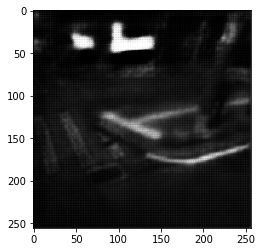

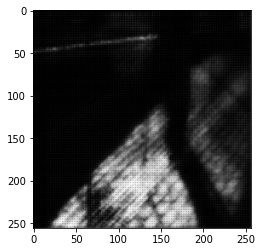

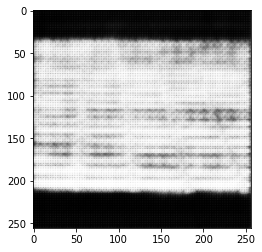

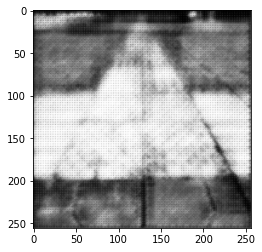

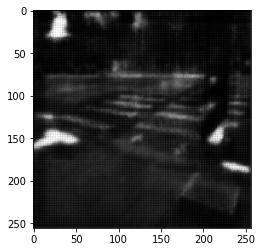

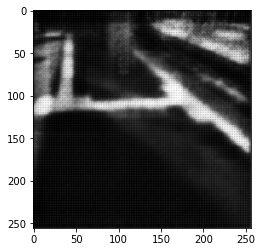

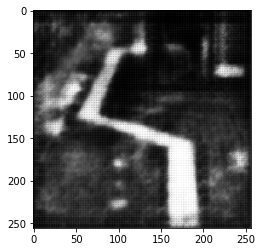

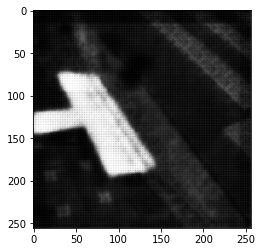

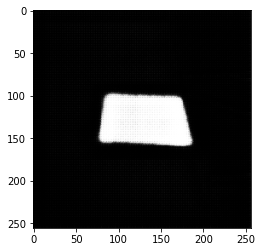

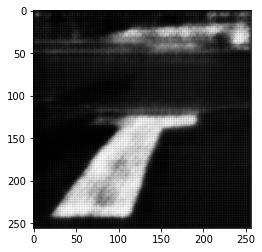

In [100]:
pred = tactile_fcn(torch.Tensor(tactile_train_x[90:]).float().cuda())
pred = nn.functional.sigmoid(pred)
pred = pred.cpu().detach().numpy()

for i in range(10):
    plt.imshow(np.transpose(pred[i]), cmap="gray")
    plt.show()

In [101]:
test1 = cv2.cvtColor(cv2.imread("./test_tactile1.jpg"), cv2.COLOR_BGR2RGB)

In [102]:
test1 = cv2.resize(test1, dsize=(256, 256))

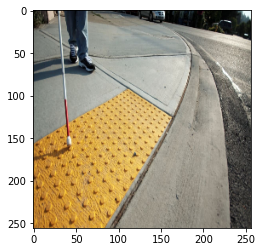

In [103]:
plt.imshow(test1)

In [104]:
test1 = np.transpose(test1)

pred = tactile_fcn(torch.Tensor(np.array([test1])).float().cuda())
pred = nn.functional.sigmoid(pred)
pred = pred.cpu().detach().numpy()

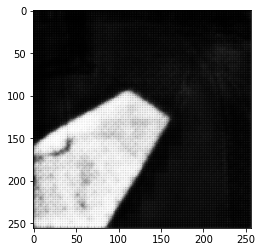

In [105]:
plt.imshow(np.transpose(pred[0][0]), cmap="gray")

In [106]:
torch.save(tactile_fcn.state_dict, "./tactile_fcn_weights.pkl")